In [1]:
# Gestión de la memoria

# PyTorch utiliza un asignador de memoria de almacenamiento en caché para acelerar 
# las asignaciones de memoria. Esto permite una rápida desasignación de memoria 
# sin sincronizaciones de dispositivos. Sin embargo, la memoria no utilizada
# administrada por el asignador todavía se mostrará como si se usara en nvidia-smi. 
# Puede usar memory_allocated () y max_memory_allocated () para monitorear la memoria
# ocupada por los tensores, y use memory_cached () y max_memory_cached () para monitorear
# la memoria administrada por el asignador de almacenamiento en caché. 
# Llamar a empty_cache () libera toda la memoria caché no utilizada de PyTorch para 
# que otras aplicaciones de GPU puedan usarla. Sin embargo, la memoria de GPU ocupada
# por los tensores no se liberará, por lo que no puede aumentar la cantidad de memoria
# de GPU disponible para PyTorch.

In [2]:
experimento = 'Experimento para entrenar un modelo que se ha entrneado en dos partes, con todos los datos y luego con solo las clases problematicas'

In [3]:
#Importamos las librerias necesarias
import torch
import numpy as np
import pandas as pd
import Modulo_MLP
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
def evaluate_aux(model, test_loader):
        """
        Evalua el modelo previamente entrnado
        Argumentos de entrada: modelo, conjunto de test
        """
        model.eval()
        model.to(device)
        acc = []
        with torch.no_grad():
            for batch in test_loader:
                X, y = batch
                y_hat = model(X.float())
                acc.append((y == torch.argmax(y_hat, axis=1)).sum().item() / len(y))

        return np.mean(acc)


In [5]:
#device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
#Cargamos el data set
data = pd.read_csv('C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/Jaime/TFG/HuGaDB-master/HuGaDB_v2_Digest/DataFrameFinal.csv')

#Elimino las filas con algún valor de columna vacio 
data = data.dropna()

In [7]:
print(f'\033[5;35m EXPERIMENTO --> {experimento} \033[0;m')

 EXPERIMENTO --> Experimento para entrenar un modelo que se ha entrneado en dos partes, con todos los datos y luego con solo las clases problematicas 


In [8]:
#hyper parameters
    #Numero de muestras del todo el dataset, numero de entradas de la red, numero de clases a clasificar, 
    # numero de neuronas en la capa oculta, numero de epocas, numero de lotes, tasa de aprendizaje, k del K-Fold

nTest = 0.2   
nSamples = 800000

nTrain = 1-nTest
nSamples =  round(nSamples / nTrain)

input_size = 38
num_classes = 12

hidden_size = 300
num_epochs = 500
batch_size = 256
# hidden_size = 200
# num_epochs = 1000
# batch_size = 256
learning_rate = 0.01
# list_learning_rate = [1e-3, 1e-2, 1e-1]   #lr tiene incremento logaritmico 10^-2 --> 0.01

num_splits = 10

# class_names = ['Walking', 'Running', 'Going up', 'Going down', 'Sitting', 'Sitting down', 'Standing up', 'Standing', 
#                'Bicycling', 'Up by elevator',  'Down by elevator',  'Sitting in car', ] 
# class_names = ['Walking', 'Running', 'Going up', 'Going down', 'Sitting', 'Sitting down', 'Standing up', 'Standing', 
#                 'Up by elevator',  'Down by elevator'] 
class_names = ['Walking', 'Running', 'Going up', 'Going down', 'Sitting', 'Sitting down', 'Standing up', 'Standing', 
                'Up by elevator',  'Down by elevator'] 
labels = [1,2,3,4,5,6,7,8,10,11]

In [9]:
# Obtengo un subconjunto del data set original 
# TODO Conocer la distribución de cada clase 
df = data
# df = df[nSamples:(nSamples+500000)]
df = df[nSamples:]

In [10]:
# df = df[(df.act == 1) | (df.act == 2) | (df.act == 3) | (df.act == 4) | (df.act == 5) | (df.act == 6) | (df.act == 7) 
#         | (df.act == 8) | (df.act == 10) | (df.act == 11)]
# # Elimino las muesta correpondientes a las actividades subir y bajar ascensor(10, 11)

# df = df[(df.act == 1) | (df.act == 2) | (df.act == 3) | (df.act == 4) | (df.act == 5) | (df.act == 6) | (df.act == 7) 
#         | (df.act == 8) | (df.act == 9) | (df.act == 12)]

# df = df[(df.act == 8) | (df.act == 10) | (df.act == 11)]

In [11]:
#Divido el conjunto de muestras en variable clasificatoria(y) y las demas(X)

X = df.drop(['act'], axis = 'columns')
# X.head()

y = df.act
# y.head()

num of samples: 137985
[38248, 8076, 16300, 14689, 10082, 2177, 2532, 26883, 0, 10769, 8229, 0]


<BarContainer object of 12 artists>

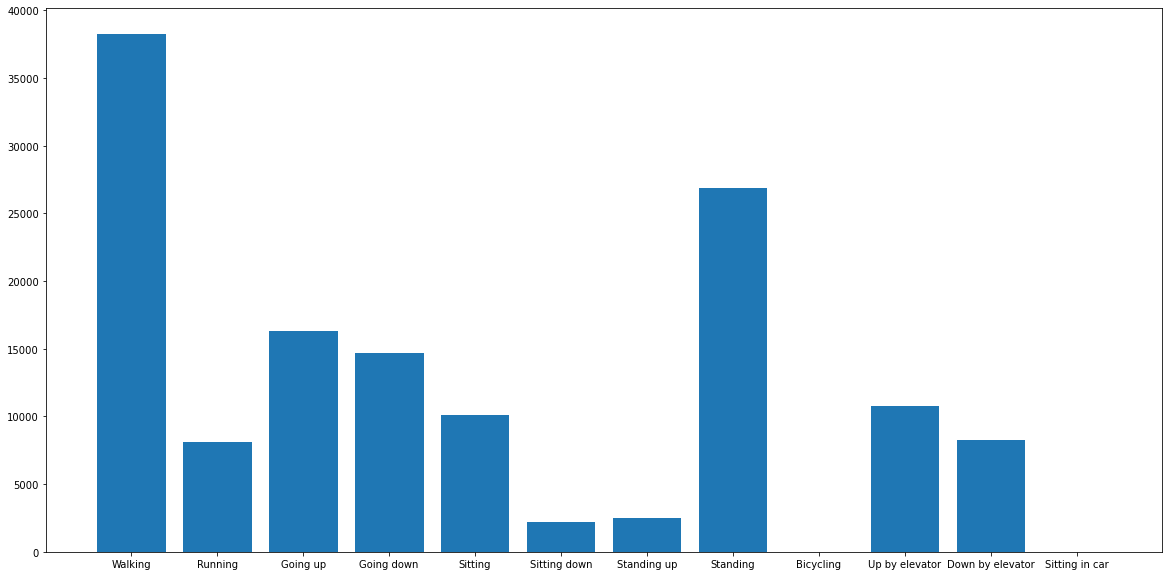

In [12]:
x_values =  ['Walking', 'Running', 'Going up', 'Going down', 'Sitting', 'Sitting down', 'Standing up', 'Standing', 
               'Bicycling', 'Up by elevator',  'Down by elevator',  'Sitting in car', ] 
y_values = []
y_values.append((df[(df.act == 1)]).shape[0])
y_values.append((df[(df.act == 2)]).shape[0])
y_values.append((df[(df.act == 3)]).shape[0])
y_values.append((df[(df.act == 4)]).shape[0])
y_values.append((df[(df.act == 5)]).shape[0])
y_values.append((df[(df.act == 6)]).shape[0])
y_values.append((df[(df.act == 7)]).shape[0])
y_values.append((df[(df.act == 8)]).shape[0])
y_values.append((df[(df.act == 9)]).shape[0])
y_values.append((df[(df.act == 10)]).shape[0])
y_values.append((df[(df.act == 11)]).shape[0])
y_values.append((df[(df.act == 12)]).shape[0])
print(f'num of samples: {sum(y_values)}')
print(y_values)
plt.figure(figsize=(20,10))
plt.bar(x_values, y_values, width=0.8)                

In [13]:
# # Porcentaje de cada clase en un conjunto de datos
# s = sum(y_values)
# w = 0
# for x in y_values:
#     y = x * 100
#     z = y / s
#     w = w + z
#     print(f'La muestra es {x} y su porcentaje es {z}')
# print(f'Total: {w}')

In [14]:
#Obtengo los valores de los conjuntos anteriores
X_val = X.values
y_val = y.values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_val,y_val,test_size=nTest, random_state=0)

In [16]:
X_tensor = torch.tensor(X_test).cuda()
y_tensor = torch.tensor(y_test).cuda()
testset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [17]:
# #'modelo_final_'+str(now.date())+'_'+str(round(acc_test, 4))+'_Train'+'.zip'
modelo_pre_train = torch.jit.load('modelo_final_2021-06-05_0.8098_Test.zip')
print(f'\033[1;36mPrecisión del modelo con doble entreno y observaciones nunca vistas --> {evaluate_aux(modelo_pre_train, test_loader)} \033[0;m')

# modelo_pre_train = None

Precisión del modelo con doble entreno y observaciones nunca vistas --> 0.8099154175135501 


  0%|          | 0/500 [00:00<?, ?it/s]

######### Launch with 1000000 Samples, 500 Epochs, 256      Batch, 10 Splits, 12 Class, 300 Hidden neurons ######### 
Entro en modelo preentrnado


loss 0.48304 acc 0.76968:  20%|██        | 100/500 [1:03:39<4:09:07, 37.37s/it]

OVERFFITING|Epochs: 100/500|Loss test old: 0.6189454188989433|loss test new: 0.6190797972814603


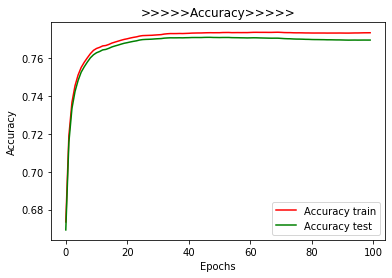

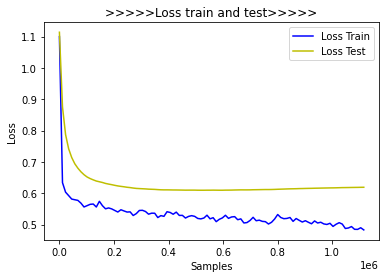

Accuracy de validación con kFold 0.7486855067815249
Accuracy Train: 0.7511867231945502 
Accuracy Test: 0.7477986737688879 
Diferencia entre train y test: 0.0033880494256622873

 


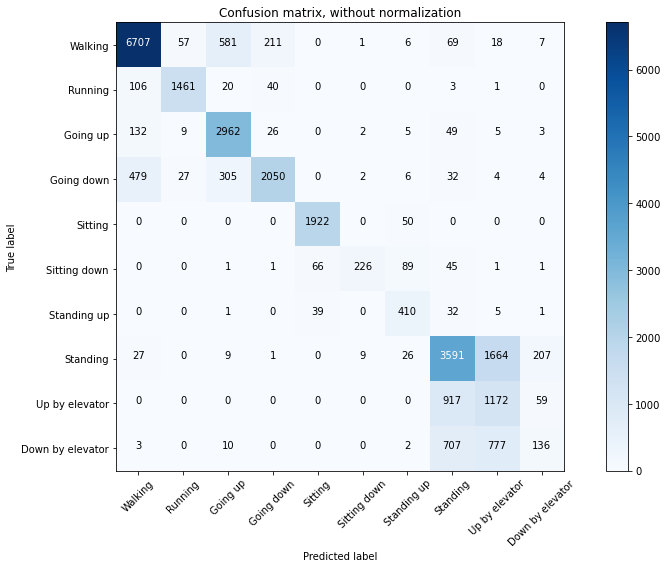

Entro en modelo preentrnado


loss 0.47814 acc 0.77087:   2%|▏         | 11/500 [06:52<5:06:36, 37.62s/it]

KeyboardInterrupt: 

In [18]:
print(f'\033[1;36m######### Launch with {nSamples} Samples, {num_epochs} Epochs, {batch_size}\
      Batch, {num_splits} Splits, {num_classes} Class, {hidden_size} Hidden neurons ######### \033[0;m')
#  Llamo al metodo que implementa el K-fold
time_mean, modelo_trained, loss_test_list, list_acc_test = Modulo_MLP.CV_Kfold(device, num_classes, input_size, X_train, 
                                                               y_train,hidden_size,num_splits,batch_size,num_epochs,
                                                               learning_rate, (X_test, y_test), modelo_pre_train, class_names, labels)

In [ ]:
# Calacular el accuracy de test con un conjunto nunca antes visto 
d = data[800000:900000]

# d = d[(d.act == 1) | (d.act == 2) | (d.act == 3) | (d.act == 4) | (d.act == 5) | (d.act == 6) | (d.act == 7) 
#         | (d.act == 8) | (d.act == 9) | (d.act == 12)]

X_t = d.drop(['act'], axis = 'columns')
y_t = d.act

Xt_tensor = torch.tensor(X_t.values).cuda()

yt_tensor = torch.tensor(y_t.values).cuda()

testset = torch.utils.data.TensorDataset(Xt_tensor,  yt_tensor)
test_loader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle=False)

accuracy_test = Modulo_MLP.evaluate(modelo_trained.to(device),test_loader)
print(f'Accuracy de test {accuracy_test}')


# #Guardo el modelo con el accuracy de tes
# # Scripting load
# acc_label = evaluate_aux(modelo_trained.to(device), test_loader)
# scripted_model_final = torch.jit.script(modelo_trained.cpu())
# # Scripting save
# from datetime import datetime
# now = datetime.now()
# scripted_model_final.save('modelo_final_'+str(now.date())+'_'+str(round(acc_label, 4))+'_Test'+'.zip')

In [ ]:
#Libera toda la memoria caché no utilizada de PyTorch
torch.cuda.empty_cache()